In [1]:
import requests
import pandas as pd
from io import StringIO
import sqlite3
import os

monthly_air_traffic_figures = "https://opendata.muenchen.de/dataset/9a648dad-0b55-42c7-8ba6-24b7c6bcc599/resource/ad408efa-528e-409b-bfe2-e1f547992cde/download/monatszahlen2307_flugverkehr_10_07_23_nosum.csv"
monthly_weather_figures = "https://opendata.muenchen.de/dataset/d7e42935-8884-40d3-9284-096d9cafecdd/resource/64c8c183-7fd0-4b29-9958-4169d22ee883/download/monatszahlen2307_witterung_10_07_23_nosum.csv"

air_response = requests.get(monthly_air_traffic_figures)
weather_response= requests.get(monthly_weather_figures)

air_data = air_response.text
weather_data = weather_response.text

air_df = pd.read_csv(StringIO(air_data))


weather_df = pd.read_csv(StringIO(weather_data))

preprocessing of Air traffic data 

In [2]:
air_df=air_df.drop(air_df.iloc[:, [0, 1]], axis=1)
air_df=air_df.rename(columns={"JAHR":"Year","MONAT":"Month",
                       "WERT":"value","VORJAHRESWERT":"Previous_year",
                       "VERAEND_VORMONAT_PROZENT":"Previous_month_percent",
                       "VERAEND_VORJAHRESMONAT_PROZENT":"previous_year",
                       "ZWOELF_MONATE_MITTELWERT":"tweleve_month_average"})
air_df.Month=air_df.Month.str[4:]
airrr_df = air_df[['Year', 'Month']].drop_duplicates()
airrr_df['number_of_passengers']=air_df["value"]
air_df=airrr_df
air_df

,Year,Month,number_of_passengers
0,2023,e,13986737.0
1,2023,01,1143963.0
2,2023,02,1079314.0
3,2023,03,1279153.0
4,2023,04,1480583.0
...,...,...,...
306,2000,08,1049151.0
307,2000,09,1187916.0
308,2000,10,1053543.0
309,2000,11,957451.0


preprceesing of weather data

In [3]:
weather_df=weather_df.drop(weather_df.iloc[:, [1]], axis=1)


weather_df=weather_df.rename(columns={"MONATSZAHL":"TYPE","JAHR":"Year","MONAT":"Month",
                       "WERT":"value","VORJAHRESWERT":"Previous_year",
                       "VERAEND_VORMONAT_PROZENT":"Previous_month_percent",
                       "VERAEND_VORJAHRESMONAT_PROZENT":"previous_year",
                       "ZWOELF_MONATE_MITTELWERT":"tweleve_month_average"})


In [4]:
weather_df.Month=weather_df.Month.str[4:]

In [5]:
for i,row in weather_df.iterrows():
    if weather_df.TYPE[i]=="Luftfeuchtigkeit":
        weather_df.TYPE[i]="Humidity"
    elif weather_df.TYPE[i]=="Lufttemperatur":
        weather_df.TYPE[i]="Air_Temperature"
    elif weather_df.TYPE[i]=="Niederschlag":
        weather_df.TYPE[i]="Precipitation"
    else:
        weather_df.TYPE[i]="Sunshine"

C:\Users\rajes\AppData\Local\Temp\ipykernel_18512\391143384.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df.TYPE[i]="Humidity"
C:\Users\rajes\AppData\Local\Temp\ipykernel_18512\391143384.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df.TYPE[i]="Air_Temperature"
C:\Users\rajes\AppData\Local\Temp\ipykernel_18512\391143384.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df.TYPE[i]="Precipitation"
C

In [6]:
Humidity = weather_df.loc[weather_df.TYPE=='Humidity']
Sunshine = weather_df.loc[weather_df.TYPE=='Sunshine']
Air_Temperature = weather_df.loc[weather_df.TYPE=='Air_Temperature']
Precipitation = weather_df.loc[weather_df.TYPE=='Precipitation']

In [7]:
Humidity=Humidity.iloc[:, [1,2,3]]
Sunshine=Sunshine.iloc[:, [1,2,3]]
Precipitation=Precipitation.iloc[:, [1,2,3]]
Air_Temperature=Air_Temperature.iloc[:, [1,2,3]]

In [8]:
Humidity=Humidity.rename(columns={"value":"Humidity_value"})
Precipitation=Precipitation.rename(columns={"value":"Precipitation_value"})
Air_Teperature=Air_Temperature.rename(columns={"value":"Air_temp_value"})
Sunshine=Sunshine.rename(columns={"value":"Sunshine_value"})

In [9]:
weather = pd.merge(Humidity, Precipitation, on=['Year', 'Month'])
weather = pd.merge(weather, Air_Teperature, on=['Year', 'Month'])
weather = pd.merge(weather,Sunshine, on=['Year', 'Month'])
weather_unique = weather[['Year', 'Month']].drop_duplicates()
result_df = pd.DataFrame(weather_unique)
result_df['Humidity'] = weather['Humidity_value']
result_df['Precipitation'] = weather['Precipitation_value']
result_df['Air_Temperature'] = weather['Air_temp_value']
result_df['Sunshine'] = weather['Sunshine_value']
weather_df=result_df
weather_df=weather_df.reset_index(drop=True)

merging both the table for the analysis

In [10]:
tab=pd.merge(weather_df, air_df, on=['Year', 'Month'])
tab

,Year,Month,Humidity,Precipitation,Air_Temperature,Sunshine,number_of_passengers
0,2023,01,77.0,18.0,18.5,56.0,1143963.0
1,2023,02,73.0,35.0,16.4,118.0,1079314.0
2,2023,03,68.0,49.0,19.5,135.0,1279153.0
3,2023,04,72.0,112.0,22.5,122.0,1480583.0
4,2023,05,71.0,83.0,27.3,205.0,1609617.0
...,...,...,...,...,...,...,...
283,2000,08,70.0,173.0,33.5,250.0,1049151.0
284,2000,09,85.0,151.0,26.0,164.0,1187916.0
285,2000,10,88.0,98.0,25.6,63.0,1053543.0
286,2000,11,83.0,43.0,20.1,100.0,957451.0


In [11]:
import matplotlib.pyplot as plt

In [12]:
new=tab.groupby('Month', as_index=False)

In [13]:
lol=new.sum()
lol

,Month,Year,Humidity,Precipitation,Air_Temperature,Sunshine,number_of_passengers
0,01,48276,1929.0,1377.0,316.3,1752.0,26608231.0
1,02,48276,1798.0,1133.0,372.0,2396.0,26143273.0
2,03,48276,1650.0,1348.0,479.4,3753.0,30625602.0
3,04,48276,1530.0,1322.0,593.7,4713.0,31296596.0
4,05,48276,1644.0,2780.0,691.4,5064.0,33617165.0
5,06,48276,1593.0,2954.0,775.9,5881.0,35870278.0
6,07,48276,1583.0,2672.0,803.7,5965.0,36631638.0
7,08,48276,1590.0,2820.0,754.8,5359.0,36275393.0
8,09,48276,1752.0,1863.0,640.7,3971.0,39823190.0
9,10,48276,1843.0,1517.0,565.3,2978.0,34784036.0


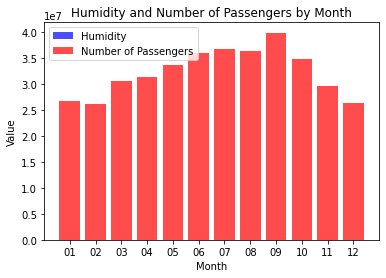

In [14]:
plt.bar(lol['Month'], lol['Humidity'], color='blue', alpha=0.7, label='Humidity')
plt.bar(lol['Month'], lol['number_of_passengers'], color='red', alpha=0.7, label='Number of Passengers')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Humidity and Number of Passengers by Month')
plt.legend()
plt.show()

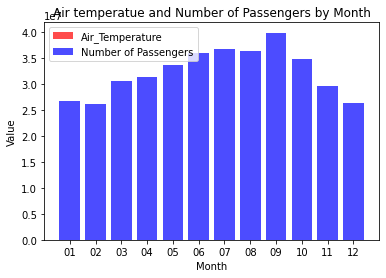

In [15]:
plt.bar(lol['Month'], lol['Air_Temperature'], color='red', alpha=0.7, label='Air_Temperature')
plt.bar(lol['Month'], lol['number_of_passengers'], color='blue', alpha=0.7, label='Number of Passengers')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Air temperatue and Number of Passengers by Month')
plt.legend()
plt.show()

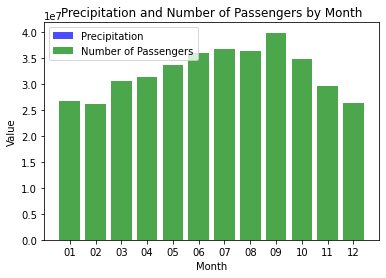

In [16]:
plt.bar(lol['Month'], lol['Precipitation'], color='blue', alpha=0.7, label='Precipitation')
plt.bar(lol['Month'], lol['number_of_passengers'], color='green', alpha=0.7, label='Number of Passengers')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Precipitation and Number of Passengers by Month')
plt.legend()
plt.show()

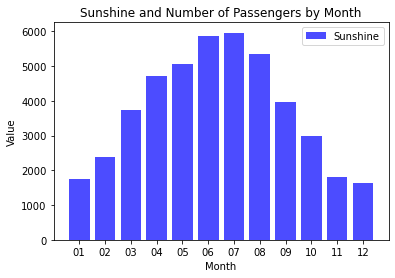

In [17]:
plt.bar(lol['Month'], lol['Sunshine'], color='blue', alpha=0.7, label="Sunshine")
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Sunshine and Number of Passengers by Month')
plt.legend()
plt.show()

In [18]:
yea=tab.groupby('Year', as_index=False)
year_df=yea.sum()

In [19]:
year_df

,Year,Humidity,Precipitation,Air_Temperature,Sunshine,number_of_passengers
0,2000,918.0,1192.0,285.5,1842.0,11465074.0
1,2001,952.0,1053.0,271.3,1829.0,11755987.0
2,2002,905.0,1127.0,278.1,1856.0,11493903.0
3,2003,810.0,657.0,287.7,2172.0,12021122.0
4,2004,869.0,814.0,275.2,1784.0,13357210.0
5,2005,901.0,1017.0,273.8,1901.0,14270304.0
6,2006,895.0,855.0,273.1,1997.0,15365373.0
7,2007,876.0,1072.0,275.8,1988.0,16975297.0
8,2008,889.0,860.0,287.4,1907.0,17257517.0
9,2009,894.0,918.0,276.3,1798.0,16329161.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


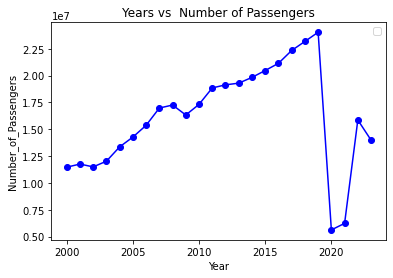

In [52]:
plt.plot(year_df['Year'], year_df["number_of_passengers"], marker='o', linestyle='-', color='blue')
plt.xlabel('Year')
plt.ylabel('Number_of_Passengers')
plt.title('Years vs  Number of Passengers')
plt.legend()
plt.show()

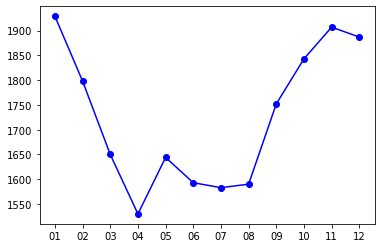

In [21]:
plt.plot(lol['Month'], lol["Humidity"], marker='o', linestyle='-', color='blue')

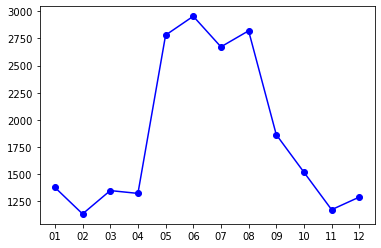

In [22]:
plt.plot(lol['Month'], lol["Precipitation"], marker='o', linestyle='-', color='blue')

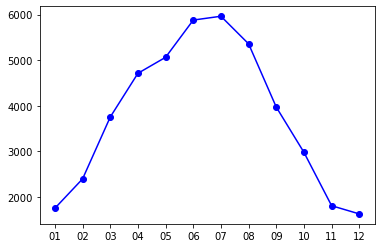

In [23]:
plt.plot(lol['Month'], lol["Sunshine"], marker='o', linestyle='-', color='blue')

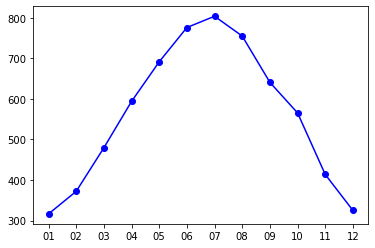

In [24]:
plt.plot(lol['Month'], lol["Air_Temperature"], marker='o', linestyle='-', color='blue')

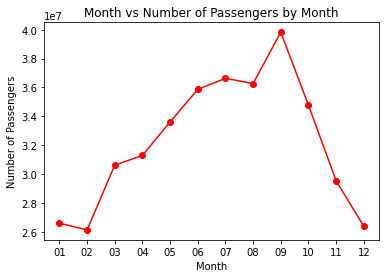

In [85]:
plt.plot(lol['Month'], lol["number_of_passengers"], marker='o', linestyle='-', color='red')
plt.title('Month vs Number of Passengers by Month')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.show()

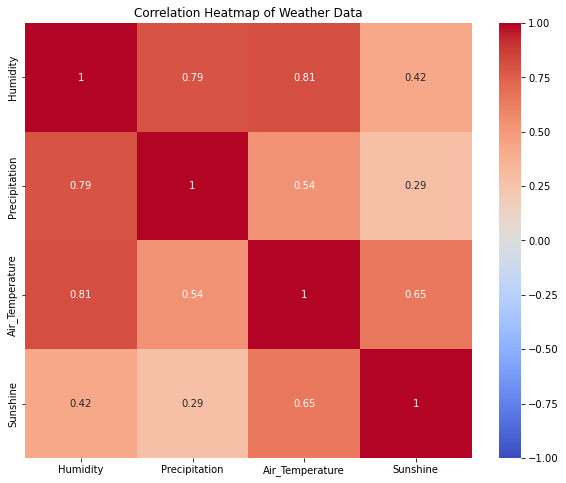

In [26]:
import seaborn as sns
selected_columns = ["Humidity","Precipitation","Air_Temperature","Sunshine"]
correlation=year_df[selected_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Weather Data')
plt.show()

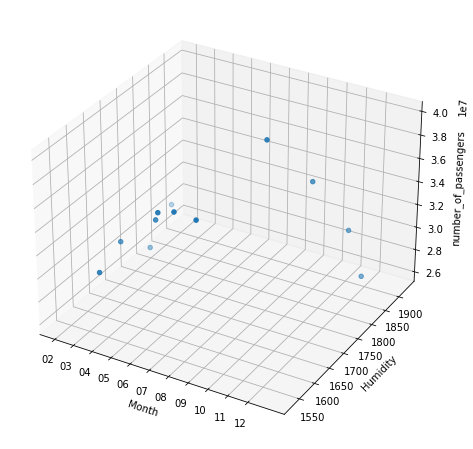

In [27]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(lol['Month'], lol['Humidity'], lol['number_of_passengers'])

ax.set_xlabel('Month')
ax.set_ylabel('Humidity')
ax.set_zlabel('number_of_passengers')

plt.show()

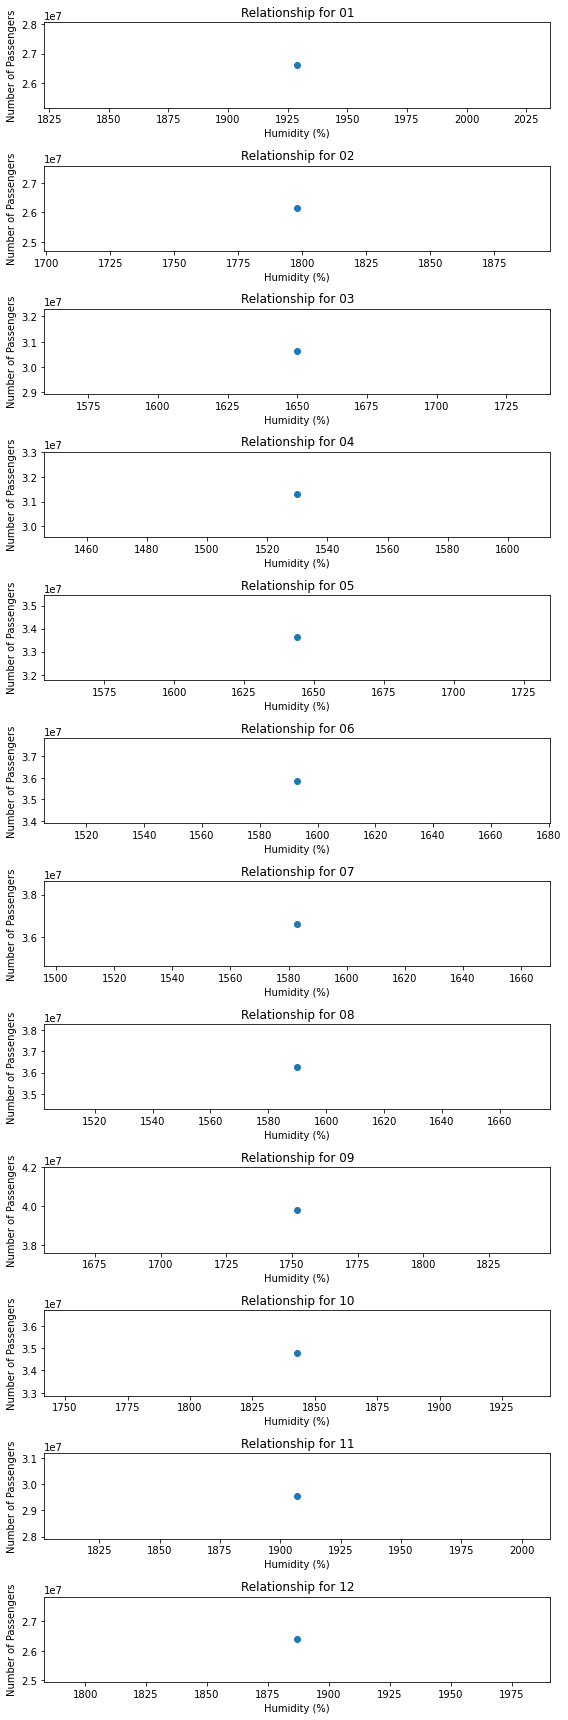

In [28]:
# Create subplots for each month
fig, axs = plt.subplots(nrows=len(lol['Month']), ncols=1, figsize=(8, 2 * len(lol['Month'])))

# Plot the relationship between Humidity and Number of Passengers for each month
for i, month in enumerate(lol['Month']):
    axs[i].scatter(lol.loc[lol['Month'] == month, 'Humidity'], lol.loc[lol['Month'] == month, 'number_of_passengers'])
    axs[i].set_title(f'Relationship for {month}')
    axs[i].set_xlabel('Humidity (%)')
    axs[i].set_ylabel('Number of Passengers')

plt.tight_layout()
plt.show()


<BarContainer object of 12 artists>

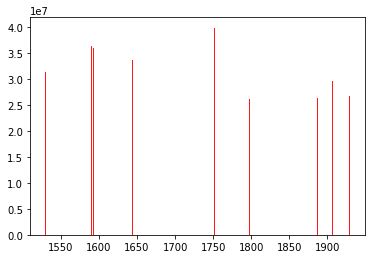

In [29]:
plt.bar(lol['Humidity'], lol['number_of_passengers'], color='red', alpha=0.9, label='Number of Passengers')

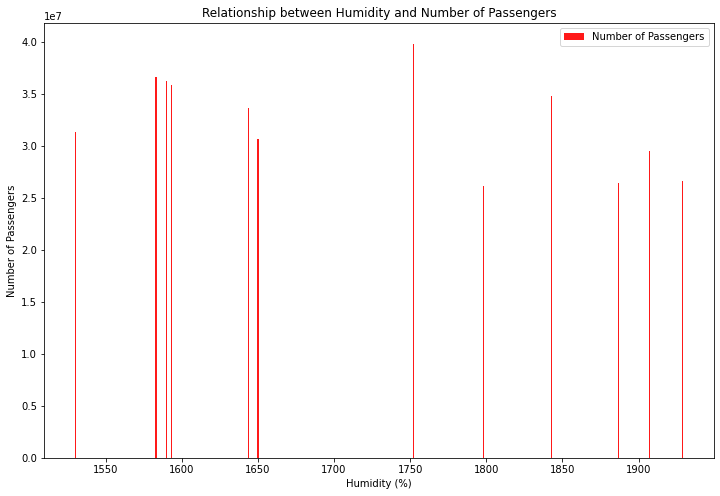

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(lol['Humidity'], lol['number_of_passengers'], color='red', alpha=0.9, label='Number of Passengers')
ax.set_xlabel('Humidity (%)')
ax.set_ylabel('Number of Passengers')
ax.set_title('Relationship between Humidity and Number of Passengers')
ax.legend()

plt.show()

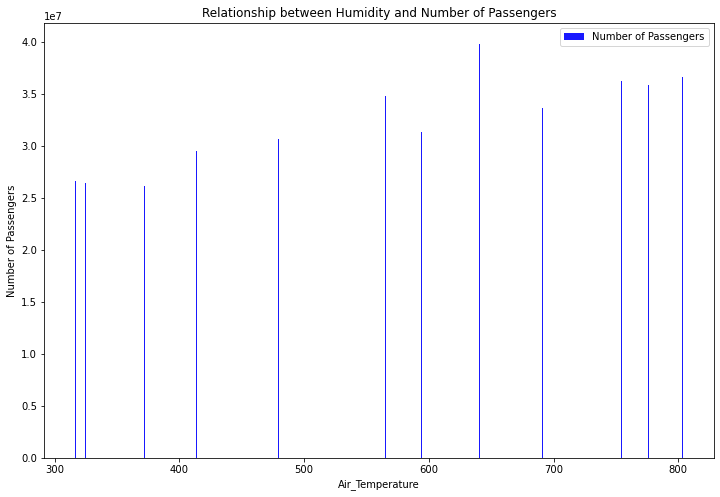

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(lol['Air_Temperature'], lol['number_of_passengers'], color='blue', alpha=0.9, label='Number of Passengers')
ax.set_xlabel('Air_Temperature')
ax.set_ylabel('Number of Passengers')
ax.set_title('Relationship between Humidity and Number of Passengers')
ax.legend()

plt.show()

NameError: name 'new_df' is not defined

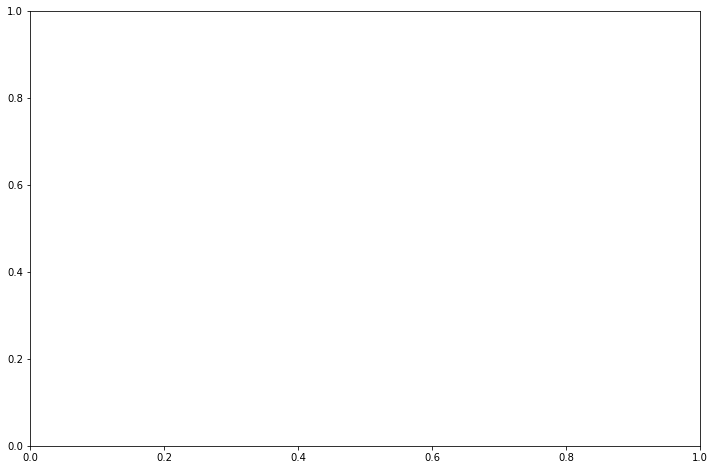

In [32]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(new_df['Sunshine'], new_df['number_of_passengers'], color='green', alpha=0.9, label='Number of Passengers')
ax.set_xlabel('Sunshine')
ax.set_ylabel('Number of Passengers')
ax.set_title('Relationship between Humidity and Number of Passengers')
ax.legend()

plt.show()

In [68]:
lol[['Sunshine','number_of_passengers','Month']]

,Sunshine,number_of_passengers,Month
0,1752.0,26608231.0,01
1,2396.0,26143273.0,02
2,3753.0,30625602.0,03
3,4713.0,31296596.0,04
4,5064.0,33617165.0,05
5,5881.0,35870278.0,06
6,5965.0,36631638.0,07
7,5359.0,36275393.0,08
8,3971.0,39823190.0,09
9,2978.0,34784036.0,10


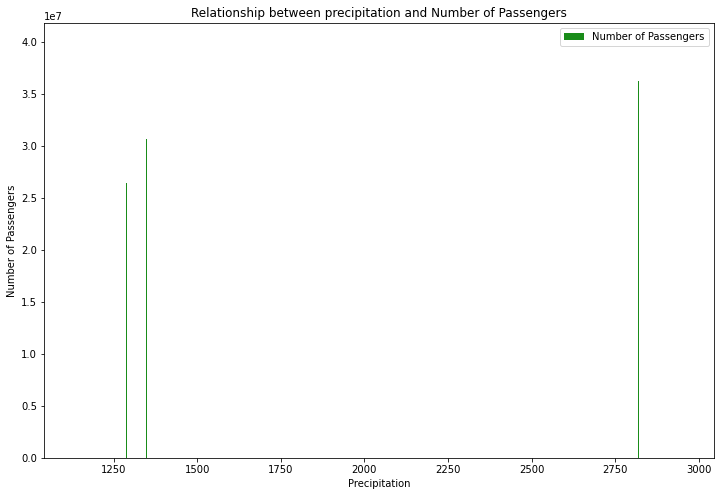

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(lol['Precipitation'], lol['number_of_passengers'], color='green', alpha=0.9, label='Number of Passengers')
ax.set_xlabel('Precipitation')
ax.set_ylabel('Number of Passengers')
ax.set_title('Relationship between precipitation and Number of Passengers')
ax.legend()

plt.show()

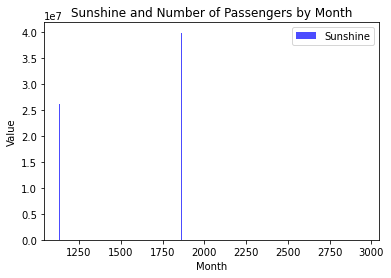

In [37]:
plt.bar(lol['Precipitation'], lol['number_of_passengers'], color='blue', alpha=0.7, label="Sunshine")
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Sunshine and Number of Passengers by Month')
plt.legend()
plt.show()


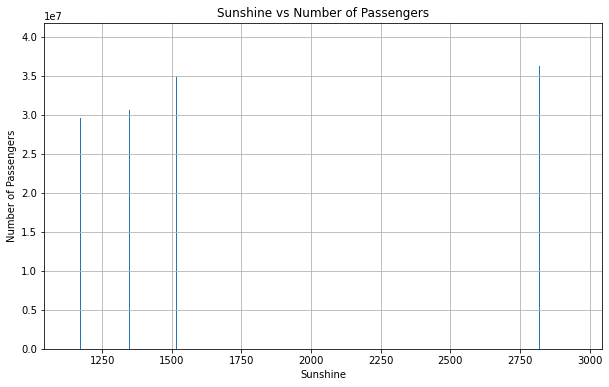

In [41]:
plt.figure(figsize=(10, 6))
plt.bar(lol['Precipitation'], lol['number_of_passengers'])
plt.title('Sunshine vs Number of Passengers')
plt.xlabel('Sunshine')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

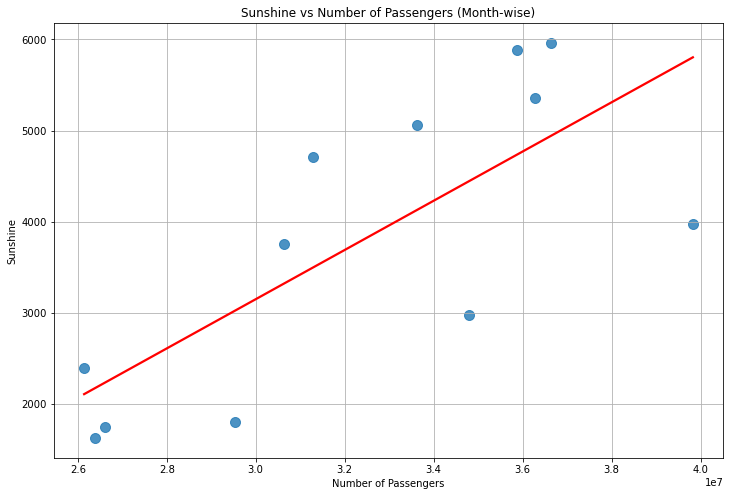

In [67]:
plt.figure(figsize=(12, 8))
sns.regplot(x=lol['number_of_passengers'], y=lol['Sunshine'], data=lol.sort_values('Month'), scatter_kws={"s": 100}, ci=None, line_kws={"color": "red"})
plt.title('Sunshine vs Number of Passengers (Month-wise)')
plt.xlabel('Number of Passengers')
plt.ylabel('Sunshine')
plt.legend(title=lol['Month'])
plt.show()

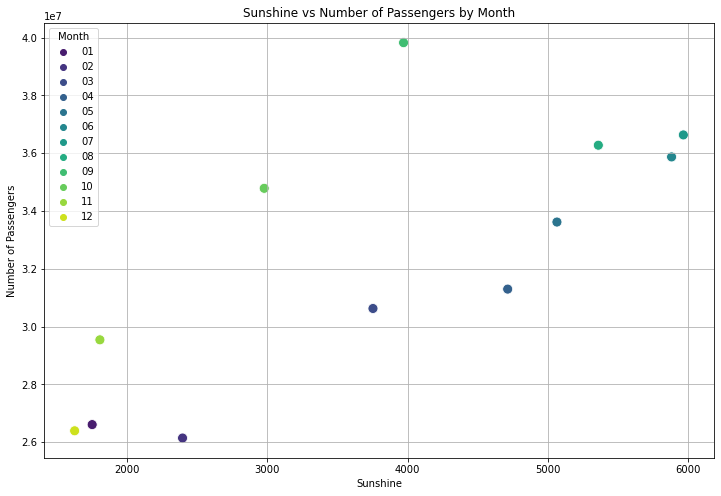

In [71]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=lol['Sunshine'], y=lol['number_of_passengers'], hue=lol['Month'], data=lol, palette='viridis', s=100)
plt.title('Sunshine vs Number of Passengers by Month')
plt.xlabel('Sunshine')
plt.ylabel('Number of Passengers')
plt.legend(title='Month')
plt.grid(True)
plt.show()

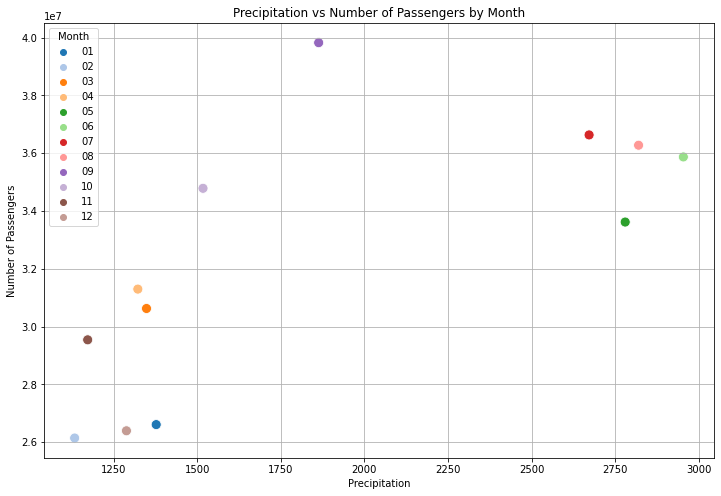

In [83]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=lol['Precipitation'], y=lol['number_of_passengers'], hue=lol['Month'], data=lol, palette='tab20', s=100)
plt.title('Precipitation vs Number of Passengers by Month')
plt.xlabel('Precipitation')
plt.ylabel('Number of Passengers')
plt.legend(title='Month')
plt.grid(True)
plt.show()

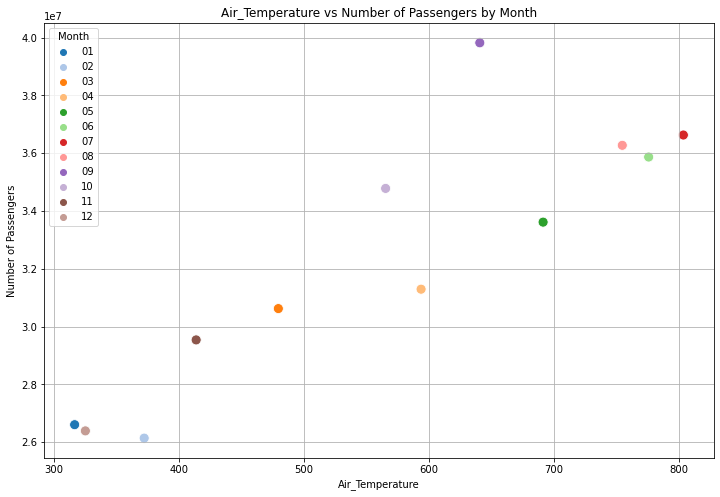

In [84]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=lol['Air_Temperature'], y=lol['number_of_passengers'], hue=lol['Month'], data=lol, palette='tab20', s=100)
plt.title('Air_Temperature vs Number of Passengers by Month')
plt.xlabel('Air_Temperature')
plt.ylabel('Number of Passengers')
plt.legend(title='Month')
plt.grid(True)
plt.show()

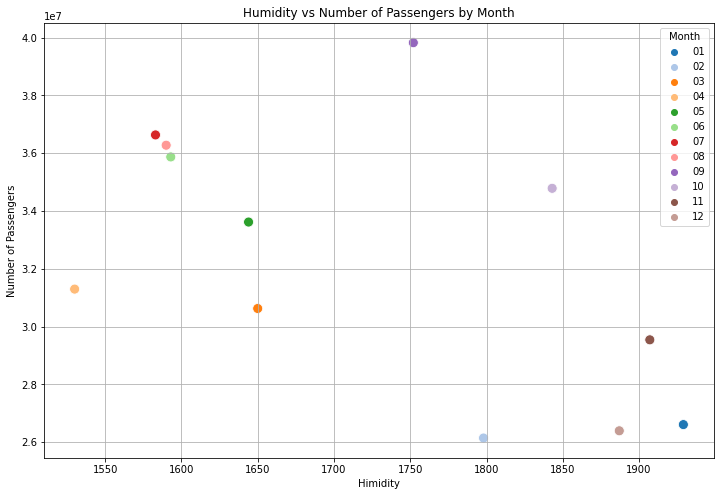

In [82]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=lol['Humidity'], y=lol['number_of_passengers'], hue=lol['Month'], data=lol, palette='tab20', s=100)
plt.title('Humidity vs Number of Passengers by Month')
plt.xlabel('Himidity')
plt.ylabel('Number of Passengers')
plt.legend(title='Month')
plt.grid(True)
plt.show()

In [86]:
lol

,Month,Year,Humidity,Precipitation,Air_Temperature,Sunshine,number_of_passengers
0,01,48276,1929.0,1377.0,316.3,1752.0,26608231.0
1,02,48276,1798.0,1133.0,372.0,2396.0,26143273.0
2,03,48276,1650.0,1348.0,479.4,3753.0,30625602.0
3,04,48276,1530.0,1322.0,593.7,4713.0,31296596.0
4,05,48276,1644.0,2780.0,691.4,5064.0,33617165.0
5,06,48276,1593.0,2954.0,775.9,5881.0,35870278.0
6,07,48276,1583.0,2672.0,803.7,5965.0,36631638.0
7,08,48276,1590.0,2820.0,754.8,5359.0,36275393.0
8,09,48276,1752.0,1863.0,640.7,3971.0,39823190.0
9,10,48276,1843.0,1517.0,565.3,2978.0,34784036.0


In [87]:
new=tab.groupby('Month', as_index=False)
mon=new.mean()

In [89]:
mon

,Month,Year,Humidity,Precipitation,Air_Temperature,Sunshine,number_of_passengers
0,01,2011.5,80.375000,57.375000,13.179167,73.000000,1.108676e+06
1,02,2011.5,74.916667,47.208333,15.500000,99.833333,1.089303e+06
2,03,2011.5,68.750000,56.166667,19.975000,156.375000,1.276067e+06
3,04,2011.5,63.750000,55.083333,24.737500,196.375000,1.304025e+06
4,05,2011.5,68.500000,115.833333,28.808333,211.000000,1.400715e+06
5,06,2011.5,66.375000,123.083333,32.329167,245.041667,1.494595e+06
6,07,2011.5,65.958333,111.333333,33.487500,248.541667,1.526318e+06
7,08,2011.5,69.130435,122.608696,32.817391,233.000000,1.511475e+06
8,09,2011.5,76.173913,81.000000,27.856522,172.652174,1.659300e+06
9,10,2011.5,80.130435,65.956522,24.578261,129.478261,1.512349e+06


,Year,Month,Humidity,Precipitation,Air_Temperature,Sunshine,number_of_passengers
0,2023,01,77.0,18.0,18.5,56.0,1143963.0
1,2023,02,73.0,35.0,16.4,118.0,1079314.0
2,2023,03,68.0,49.0,19.5,135.0,1279153.0
3,2023,04,72.0,112.0,22.5,122.0,1480583.0
4,2023,05,71.0,83.0,27.3,205.0,1609617.0
...,...,...,...,...,...,...,...
283,2000,08,70.0,173.0,33.5,250.0,1049151.0
284,2000,09,85.0,151.0,26.0,164.0,1187916.0
285,2000,10,88.0,98.0,25.6,63.0,1053543.0
286,2000,11,83.0,43.0,20.1,100.0,957451.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


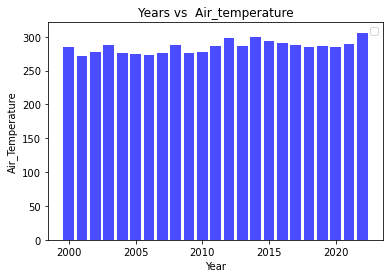

In [99]:
plt.bar(year_df['Year'], year_df["Air_Temperature"], color='blue', alpha=0.7, label="")
plt.xlabel('Year')
plt.ylabel('Air_Temperature')
plt.title('Years vs  Air_temperature')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


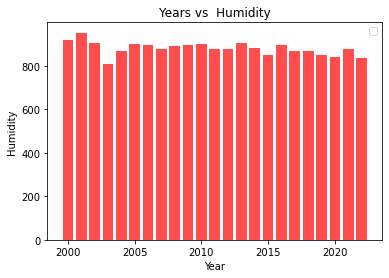

In [100]:
plt.bar(year_df['Year'], year_df["Humidity"], color='red', alpha=0.7, label="")
plt.xlabel('Year')
plt.ylabel('Humidity')
plt.title('Years vs  Humidity')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


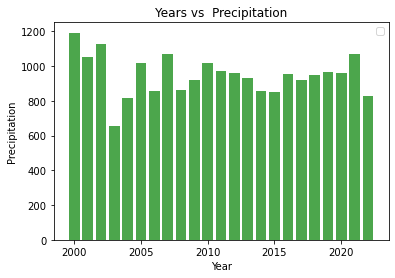

In [103]:
plt.bar(year_df['Year'], year_df["Precipitation"], color='green', alpha=0.7, label="")
plt.xlabel('Year')
plt.ylabel('Precipitation')
plt.title('Years vs  Precipitation')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


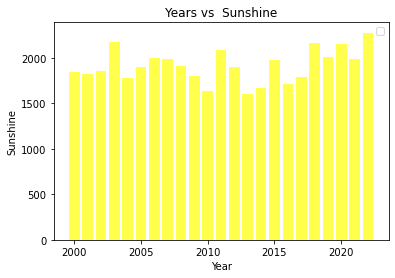

In [104]:
plt.bar(year_df['Year'], year_df["Sunshine"], color='yellow', alpha=0.7, label="")
plt.xlabel('Year')
plt.ylabel('Sunshine')
plt.title('Years vs  Sunshine')
plt.legend()
plt.show()

In [94]:
year_df

,Year,Humidity,Precipitation,Air_Temperature,Sunshine,number_of_passengers
0,2000,918.0,1192.0,285.5,1842.0,11465074.0
1,2001,952.0,1053.0,271.3,1829.0,11755987.0
2,2002,905.0,1127.0,278.1,1856.0,11493903.0
3,2003,810.0,657.0,287.7,2172.0,12021122.0
4,2004,869.0,814.0,275.2,1784.0,13357210.0
5,2005,901.0,1017.0,273.8,1901.0,14270304.0
6,2006,895.0,855.0,273.1,1997.0,15365373.0
7,2007,876.0,1072.0,275.8,1988.0,16975297.0
8,2008,889.0,860.0,287.4,1907.0,17257517.0
9,2009,894.0,918.0,276.3,1798.0,16329161.0


In [96]:
year_df=year_df.drop(23)

In [97]:
year_df

,Year,Humidity,Precipitation,Air_Temperature,Sunshine,number_of_passengers
0,2000,918.0,1192.0,285.5,1842.0,11465074.0
1,2001,952.0,1053.0,271.3,1829.0,11755987.0
2,2002,905.0,1127.0,278.1,1856.0,11493903.0
3,2003,810.0,657.0,287.7,2172.0,12021122.0
4,2004,869.0,814.0,275.2,1784.0,13357210.0
5,2005,901.0,1017.0,273.8,1901.0,14270304.0
6,2006,895.0,855.0,273.1,1997.0,15365373.0
7,2007,876.0,1072.0,275.8,1988.0,16975297.0
8,2008,889.0,860.0,287.4,1907.0,17257517.0
9,2009,894.0,918.0,276.3,1798.0,16329161.0
